In [2]:
# Model building
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

import pandas as pd # read csv
from imblearn.over_sampling import RandomOverSampler as ROS
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import numpy as np
import random

from tqdm import tqdm
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    print(f"Random seed set as {seed}")

set_seed(42) # Set the seed for reproducibility

Random seed set as 42


In [3]:
lr = 0.0001 # Found from trial and error
bs = 256 

EPOCHS = 10 # number of training epochs in total
highest_acc = 0.5 # Manually set for now, we want to beat a coin-flip at a minimum

# Flags
SAVE_CHECKPOINT = True
SAVE_HIGHEST = True

In [4]:
# For readability: 
data = pd.read_csv('./archive/hmnist_28_28_RGB.csv')
data.head()
classes = {0: ('AK', 'Actinic Keratoses'),  
           1:('BC' , 'Basal Cell Carcinoma'), 
           2:('BKLL', 'Benign Keratosis-like Lesions'), 
           3: ('DF', 'Dermatofibroma'),
           4: ('MN', 'Melanocytic nevi'), 
           5: ('PGH', 'Pyogenic Granulomas and Hemorrhage'), 
           6: ('M', 'Melanoma'),
           }
CLASSES = [classes[idx][0] for idx in range(len(classes))] # abbreviated form of classes
CLASSES_FULL = [classes[idx][1] for idx in range(len(classes))] # Full name of classes

CLASSES, CLASSES_FULL

(['AK', 'BC', 'BKLL', 'DF', 'MN', 'PGH', 'M'],
 ['Actinic Keratoses',
  'Basal Cell Carcinoma',
  'Benign Keratosis-like Lesions',
  'Dermatofibroma',
  'Melanocytic nevi',
  'Pyogenic Granulomas and Hemorrhage',
  'Melanoma'])

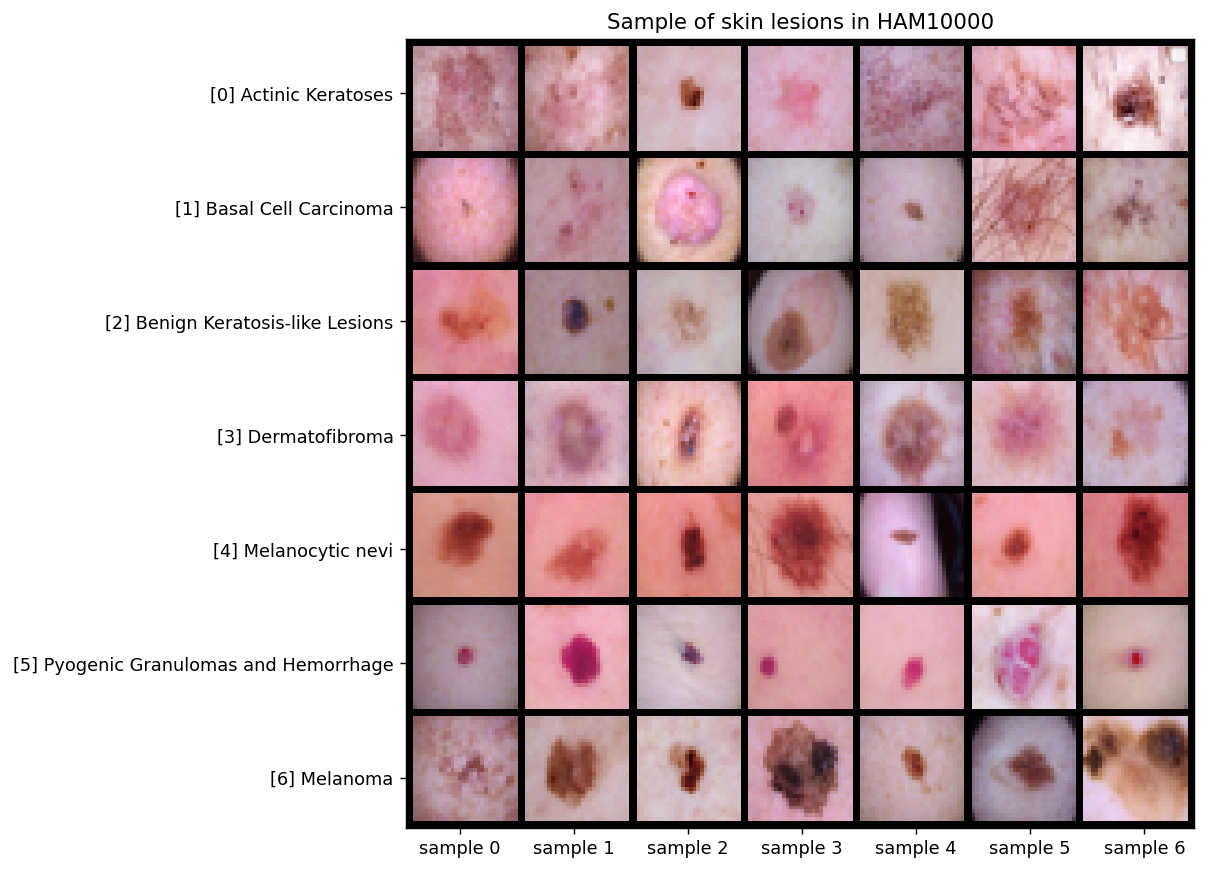

In [5]:
sample_images = []
N = len(CLASSES) # number of samples per class
for class_ in classes.keys():
    image_idxs = data.label==class_
    N_ = len(data[image_idxs])
    chosen = random.sample(list(np.arange(N_)), k= N) # creating random 7 samples per class
    images = np.asarray(data[image_idxs].iloc[chosen,:-1])# grabing those random 7 samples
    
    for img in images:
        sample_images.append(torch.tensor(img.reshape(28,28,3)).permute(2,0,1)) # obtaining one image at a time 
        
s = torch.stack(sample_images) # stack all images, convert to torch.tensor for grid
grid = torchvision.utils.make_grid(s, nrow=N) # create grid with same rows and cols

plt.figure(figsize=(8,8), dpi=(128)) # plot the grid
plt.imshow(grid.permute(1,2,0))
plt.xticks(np.linspace(14,grid.shape[2]-14,7), labels=[f'sample {idx}' for idx in range(N)])
plt.yticks(np.linspace(14,grid.shape[1]-14,7), labels=[f'[{idx}] {cls_}' for idx, cls_ in enumerate(CLASSES_FULL)])
plt.title('Sample of skin lesions in HAM10000')
plt.legend(CLASSES_FULL)
plt.show(block='off')

# Since the dataset is very unbalanced, we need to balance the dataset for more accurate training. In this case, we can use Randomized Over Sampling

/var/folders/16/_8tkc0kn25926rrc4z_87r700000gn/T/ipykernel_70108/2010049213.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train.insert(0, 'label', value=y_train.values)


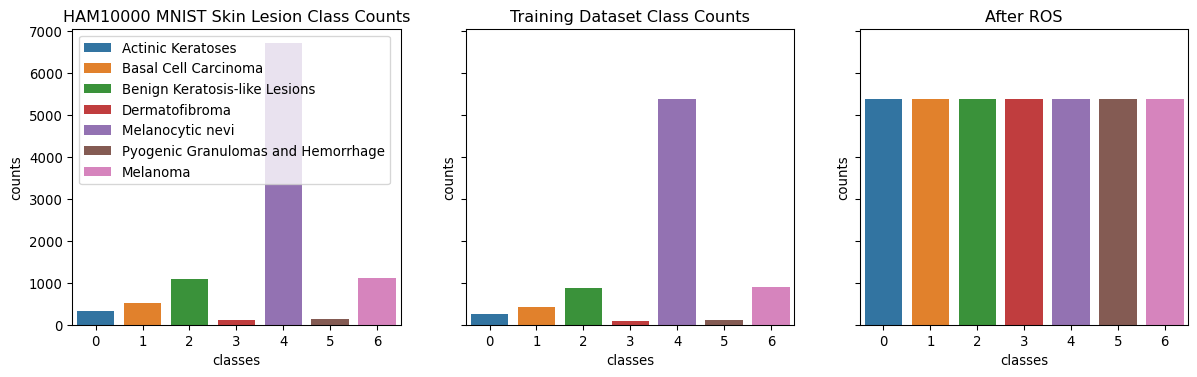

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,4), dpi=(96), sharex=True, sharey=True)

# Original dataset
x = data.drop(labels='label', axis=1) # drop the label column
y = data.label # get the label
# Plotting count
sns.countplot(x='label', ax=ax[0], hue='label', dodge=False, data=data )
ax[0].set(xlabel='classes', ylabel='counts')
ax[0].title.set_text('HAM10000 MNIST Skin Lesion Class Counts')
ax[0].legend(labels = CLASSES_FULL, loc=2)
# Split original dataframe to training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Plot number of samples in train split
x_train_ = x_train.copy()
x_train_.insert(0, 'label', value=y_train.values)
train_df_ = x_train_
sns.countplot(x=train_df_['label'], ax=ax[1])
ax[1].title.set_text('Training Dataset Class Counts')
ax[1].set(xlabel='classes', ylabel='counts')

# Create over sampler, and over sample ONLY the TRAIN dataframe
oversampler = ROS()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

# Combine train image and label dataframe as one dataframe because my dataset requires it
x_train.insert(0, 'label', value=y_train.values)
train_df = x_train

# Combine test image and label dataframe as one dataframe because my dataset requires it
x_test.insert(0, 'label', value=y_test.values)
test_df = x_test

# Print number of samples in each train/test splits
len(train_df), len(test_df)

# Plot number of samples in train split (thats oversampled); all classes should have same number of counts
sns.countplot(x=train_df['label'], ax=ax[2])
ax[2].title.set_text('After ROS')
ax[2].set(xlabel='classes', ylabel='counts')

plt.show()

# Now, we can definne a class to wrap the dataset, making it easier to use in the training loop.

In [7]:
class HAM10KDS(Dataset): # custom dataset
    def __init__(self, df):
        self.data = df # the dataframe containing the image
        self.y = self.data.label # label y
        self.x = self.data.drop(labels='label', axis=1) # drop the label, get images
        
        # Reshape the entire image array into N x height x width x RGB channel. N = number of samples
        self.x = np.asarray(self.x).reshape(-1, 28, 28,3)
        
        self.x = torch.tensor(self.x, dtype=torch.float32).permute(0, 3, 1, 2)
        
        
        self.resize = T.Resize((28*4, 28*4)) # Increase images by 4 in both dimension.

        
    def __len__(self):
        return len(self.data) # number of samples in dataset
    
    def __getitem__(self,idx):
        label = torch.tensor(self.y.iloc[idx]) # get label of image and convert to torch tensor
        
        img = self.x[idx] # get the image from the big tensor
        img = self.resize(img) # upsize the image
                                
        return img, label
        

# Here, we define our custom Neural Net. Since this is a shallow, non-convolutional model, we only have 3 linear layers.

In [8]:
class Net(nn.Module): # Custom model
    
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        self.num_classes = num_classes
        print(f'There are {self.num_classes} classes.')
            
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1), # regularisation
            nn.Flatten(),

            nn.Linear(37632, 256), 
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 256),
            nn.Sigmoid(),
            nn.BatchNorm1d(256),


            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, self.num_classes),
            nn.BatchNorm1d(self.num_classes), 
        )        

    def forward(self, x):
        return self.classifier(x)

# Here, we can put it all together and finally prepare for training.

In [9]:
# Create dataset and dataloader for train and test
train_ds = HAM10KDS(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True)

test_ds = HAM10KDS(test_df)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, pin_memory=True)

print('There are ', len(train_ds),' training samples, ', len(test_ds), ' testing samples.')

# Create our model
model = Net(len(CLASSES))

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

# Loss function. Have one for train and test/eval just in case train loss is different.
criterion = nn.CrossEntropyLoss()

There are  37569  training samples,  2003  testing samples.
There are 7 classes.


# Train the model

In [10]:
train_acc = []
train_losses = []

test_acc = []
test_losses = []

lrs = []

# For warmup
lr0 = lr*0.01

lr_step = (lr-lr0)/(len(train_dl)-1) # lr step for slow warm up from lr0 to lr 

print(f'Highest acc to beat: {highest_acc}')
best_acc = 0.90*highest_acc # use to decide whether to save a run 

print("Beginning training")
for epoch in range(EPOCHS):
        print(f"Beginning epoch {epoch}")
        loader = tqdm(train_dl)
        losses = [] # logs avg loss per epoch
        accs = [] # logs avg acc per epoch
        correct = 0 # counts how many correct predictions
        count = 0 # counts how many samples
        
        if epoch>0:
            lrs+= [optimizer.param_groups[0]['lr']]*len(train_dl) # track lr after warm up
        

        model.train()
        for bidx, (images, labels) in enumerate(loader):

            # Warm up, slowly increase fomr lr0 to lr in first epoch
            if epoch==0:
                    
                lr_ = lr0 + lr_step*bidx

                for op in optimizer.param_groups:
                    op['lr'] = lr_

                lrs.append(optimizer.param_groups[0]['lr']) # track lr

            images = images
            labels = labels
            score = model(images)
            loss = criterion(score, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                pred = torch.argmax(score, -1).detach() # need to detach else bug
                correct += (pred==labels).sum() # count how many correct
                count += len(labels)
                acc = correct/count # accumated accuracy
                
                losses.append(loss.item())
                accs.append(acc)
                
                loader.set_description(f'TRAIN | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')

        train_acc.append(acc)
        train_losses.append(torch.tensor(losses).mean().item())
                
        model.eval()
        with torch.no_grad():
            
            loader = tqdm(test_dl)
            
            losses = [] # logs loss per minibatch
            accs = [] # logs running acc throughout one epoch
            
            correct = 0 # counts how many correct predictions in one epoch
            count = 0 # counts how many samples seen in one epoch
            
            for bidx, (images, labels) in enumerate(loader):
                images = images
                labels = labels

                score = model(images)
                loss = criterion(score, labels)
                
                pred = torch.argmax(score, -1).detach() # need to detach else bug
                correct += (pred==labels).sum() # count how many correct
                count += len(labels)

                acc = correct/count # accumated accuracy
                loader.set_description(f'TEST | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')
                
                losses.append(loss.item())
                accs.append(acc)

        test_acc.append(acc)
        test_losses.append(torch.tensor(losses).mean().item())
                
        if SAVE_CHECKPOINT==True:
            if test_acc[-1]>best_acc:
                best_acc = test_acc[-1].item()

                checkpoint = {
                    'model': model,
                    'losses': [train_losses, test_losses],
                    'accs': [train_acc, test_acc],
                    'lrs': lrs,
                    'best_acc': best_acc,
                    'last_epoch_trained': epoch,
                }
                
                if best_acc > highest_acc and SAVE_HIGHEST==True:
                    old_highest_acc = highest_acc
                    highest_acc = best_acc
                    torch.save(highest_acc, 'highest_acc.pt')
                    print(f'HIGHEST ACCURACY SURPASSED from {old_highest_acc} to {highest_acc}') # save highest achieving model evahhh (yayyy! ^.^)
                    torch.save(checkpoint, f'{highest_acc:.4f} checkpoint.pt')

                torch.save(checkpoint, 'checkpoint.pt')
                print(f'Checkpointed with {best_acc:.4f} best acc')
            
        print(f"Epoch {epoch} complete")

Highest acc to beat: 0.5
Beginning training
Beginning epoch 0


TRAIN | epoch 1/10 | acc 0.4533 | loss 1.2019: 100%|██████████| 147/147 [00:37<00:00,  3.91it/s]
TEST | epoch 1/10 | acc 0.4608 | loss 1.4256: 100%|██████████| 8/8 [00:00<00:00,  9.51it/s]


Checkpointed with 0.4608 best acc
Epoch 0 complete
Beginning epoch 1


TRAIN | epoch 2/10 | acc 0.6613 | loss 0.9705: 100%|██████████| 147/147 [00:37<00:00,  3.89it/s]
TEST | epoch 2/10 | acc 0.5157 | loss 1.2625: 100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


HIGHEST ACCURACY SURPASSED from 0.5 to 0.5157263875007629
Checkpointed with 0.5157 best acc
Epoch 1 complete
Beginning epoch 2


TRAIN | epoch 3/10 | acc 0.7433 | loss 0.8324: 100%|██████████| 147/147 [00:42<00:00,  3.48it/s]
TEST | epoch 3/10 | acc 0.5212 | loss 1.1961: 100%|██████████| 8/8 [00:00<00:00,  9.11it/s]


HIGHEST ACCURACY SURPASSED from 0.5157263875007629 to 0.5212181806564331
Checkpointed with 0.5212 best acc
Epoch 2 complete
Beginning epoch 3


TRAIN | epoch 4/10 | acc 0.7868 | loss 0.7629: 100%|██████████| 147/147 [00:37<00:00,  3.96it/s]
TEST | epoch 4/10 | acc 0.5167 | loss 1.2461: 100%|██████████| 8/8 [00:00<00:00, 10.01it/s]


Epoch 3 complete
Beginning epoch 4


TRAIN | epoch 5/10 | acc 0.8170 | loss 0.7550: 100%|██████████| 147/147 [00:37<00:00,  3.91it/s]
TEST | epoch 5/10 | acc 0.5402 | loss 1.2355: 100%|██████████| 8/8 [00:00<00:00,  9.20it/s]


HIGHEST ACCURACY SURPASSED from 0.5212181806564331 to 0.5401897430419922
Checkpointed with 0.5402 best acc
Epoch 4 complete
Beginning epoch 5


TRAIN | epoch 6/10 | acc 0.8415 | loss 0.7708: 100%|██████████| 147/147 [00:43<00:00,  3.40it/s]
TEST | epoch 6/10 | acc 0.5577 | loss 1.2433: 100%|██████████| 8/8 [00:01<00:00,  7.10it/s]


HIGHEST ACCURACY SURPASSED from 0.5401897430419922 to 0.5576635003089905
Checkpointed with 0.5577 best acc
Epoch 5 complete
Beginning epoch 6


TRAIN | epoch 7/10 | acc 0.8553 | loss 0.7284: 100%|██████████| 147/147 [00:42<00:00,  3.46it/s]
TEST | epoch 7/10 | acc 0.5547 | loss 1.1396: 100%|██████████| 8/8 [00:00<00:00,  9.77it/s]


Epoch 6 complete
Beginning epoch 7


TRAIN | epoch 8/10 | acc 0.8669 | loss 0.6464: 100%|██████████| 147/147 [00:38<00:00,  3.84it/s]
TEST | epoch 8/10 | acc 0.6256 | loss 1.0546: 100%|██████████| 8/8 [00:00<00:00,  9.57it/s]


HIGHEST ACCURACY SURPASSED from 0.5576635003089905 to 0.6255616545677185
Checkpointed with 0.6256 best acc
Epoch 7 complete
Beginning epoch 8


TRAIN | epoch 9/10 | acc 0.8802 | loss 0.6718: 100%|██████████| 147/147 [00:38<00:00,  3.82it/s]
TEST | epoch 9/10 | acc 0.5667 | loss 1.2187: 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 8 complete
Beginning epoch 9


TRAIN | epoch 10/10 | acc 0.8877 | loss 0.6268: 100%|██████████| 147/147 [00:42<00:00,  3.50it/s]
TEST | epoch 10/10 | acc 0.5811 | loss 1.1688: 100%|██████████| 8/8 [00:00<00:00,  9.42it/s]

Epoch 9 complete


# Visualize the learning curve, loss, and accuracy.

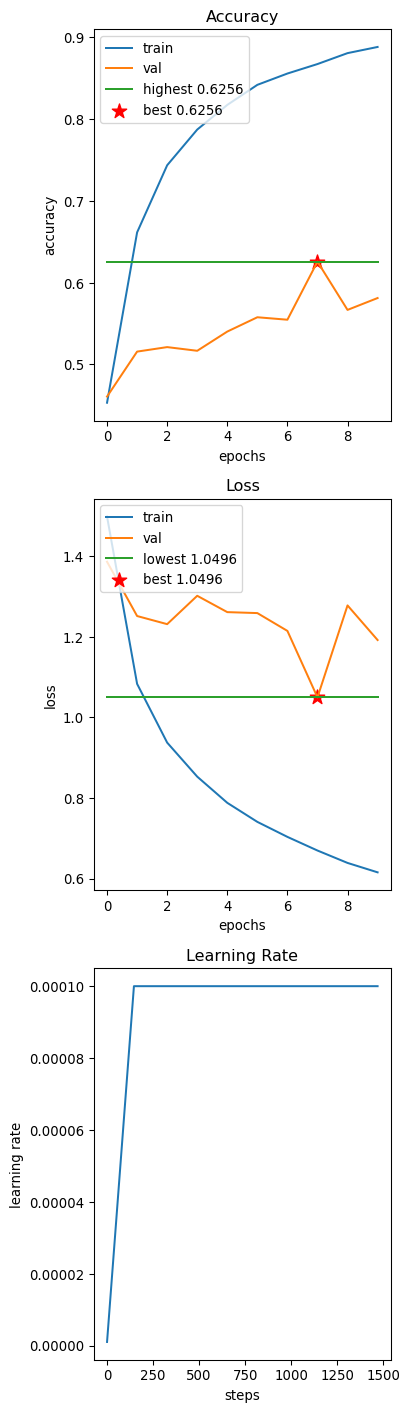

In [18]:
fig, ax = plt.subplots(3,1, figsize=(4,18), dpi=(96))

# Plotting accuracies
ax[0].plot(torch.stack(train_acc))
ax[0].plot(torch.stack(test_acc))
ax[0].plot([highest_acc]*(len(train_acc)))
ax[0].scatter(torch.argmax(torch.tensor(test_acc)).item(), torch.tensor(test_acc).max().item(), s=128, c='red', marker='*')
           
ax[0].title.set_text('Accuracy')
ax[0].set(xlabel='epochs', ylabel='accuracy')
ax[0].legend(['train', 'val', f'highest {highest_acc:.4f}', f'best {best_acc:.4f}'], loc='upper left')

# Plotting losses
ax[1].plot(train_losses)
ax[1].plot(test_losses)
ax[1].plot([torch.tensor(test_losses).min()]*len(test_losses))
ax[1].scatter(torch.argmin(torch.tensor(test_losses)).item(), torch.tensor(test_losses).min().item(), s=128, c='red', marker='*')


ax[1].title.set_text('Loss')
ax[1].set(xlabel='epochs', ylabel='loss')
ax[1].legend(['train', 'val', f'lowest {torch.tensor(test_losses).min().item():.4f}', f'best {torch.tensor(test_losses).min().item():.4f}'], loc='upper left')

# Plot learning rate
ax[2].plot(lrs)
ax[2].title.set_text('Learning Rate')
ax[2].set(xlabel='steps', ylabel='learning rate')

plt.show(block='off')

# Evaluate the model on the test set

In [12]:
# Load best accuracy checkpoint
best_model_check_point = torch.load('checkpoint.pt')
best_model = best_model_check_point['model']

# logging preds and actual for confusion matrix
preds = [] # logs model prediction each is a scalar
pred_prob = [] # logs model predictions as 7 dim prob vector
actual = [] # logs actual labels

criterion = nn.CrossEntropyLoss()

loader = tqdm(test_dl)

# Evaluate over test/val set for model prediction

best_model.eval()
with torch.no_grad():
    count = 0
    correct = 0
    losses = 0
    
    for bidx, (images, labels) in enumerate(loader):
        images = images

        actual.append(torch.flatten(labels)) # appends the labels. Flatten to remove batch dimension
        
        labels = labels
        
        score = best_model(images) # scores of B x 7
        
        prob = F.softmax(score, dim=-1) # normalise the scores as prob
       
        pred = torch.argmax(score, dim=-1)
        
        preds.append(torch.flatten(pred))
        
        correct += (pred==labels).sum()
        
        count += len(labels)
        
        pred_prob.append(torch.flatten(prob))
        
        loss = criterion(score, labels)
        
        losses += loss.item()
        
    print(f'ACC: {correct/count:.4f} | LOSS: {losses/len(test_dl)}')

100%|██████████| 8/8 [00:00<00:00, 10.18it/s]

ACC: 0.6256 | LOSS: 1.0495859906077385


# Plot the confusion matrix

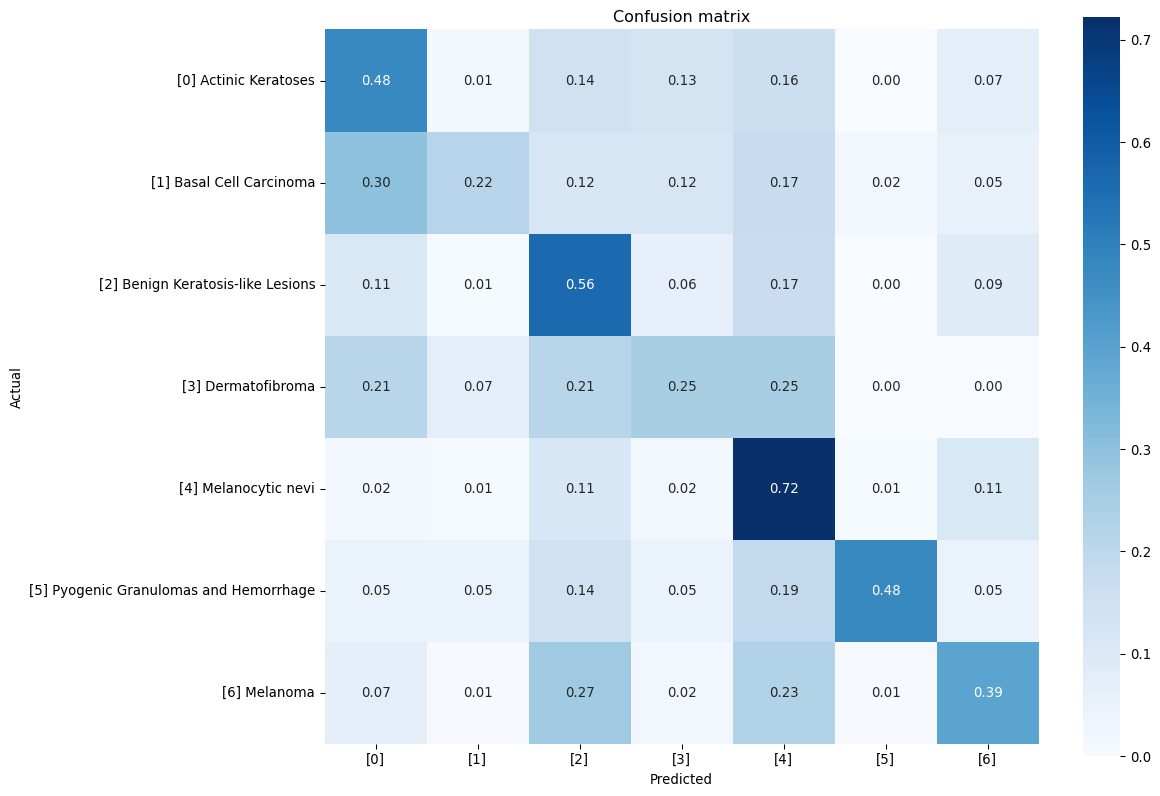

<AxesSubplot:>

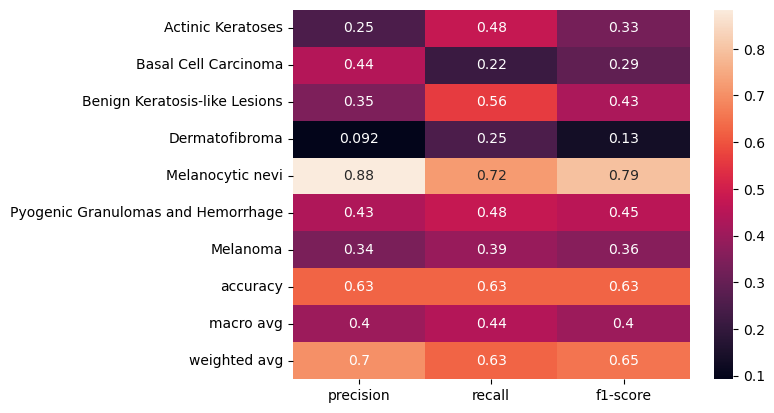

In [16]:
from sklearn.metrics import classification_report
# Reformating prediction and actual for confusion matrix
for idx, p in enumerate(preds):
    if idx>0:
        preds_ = torch.cat([preds_, p], dim=0)
    else:
        preds_ = p
        
for idx, p in enumerate(actual):
    if idx>0:
        actual_ = torch.cat([actual_, p], dim=0)
    else:
        actual_ = p
        
conf_mat = confusion_matrix(actual_, preds_) # confusion matrix

cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalise to convert count to percentage of counts
fig, ax = plt.subplots(figsize=(12,10), dpi=(96))

plt.imshow(cmn, interpolation='nearest', cmap=plt.cm.Blues)

sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=[f'[{idx}]' for idx in range(len(CLASSES))], yticklabels=[f'[{idx}] {cls}' for idx, cls in enumerate(CLASSES_FULL)])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show(block=False)
c_rep = classification_report(actual_, preds_, labels=np.arange(len(CLASSES_FULL)), target_names=CLASSES_FULL, output_dict=True)
sns.heatmap(pd.DataFrame(c_rep).iloc[:-1, :].T, annot=True)